In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('balanced_data.csv').dropna().sample(frac = 1)

In [3]:
print(len(dataset))

8058


## Preprocessing

In [272]:
from keras.preprocessing.text import Tokenizer

In [4]:
from collections import Counter

In [5]:
from nltk.stem.porter import *

In [6]:
stemmer = PorterStemmer()
comments = []
for comment in dataset['comment']:
    s = " ".join([stemmer.stem(w) for w in comment.split()])
    comments.append(s)

In [7]:
all_text = ' '.join(comments)
words = all_text.split()
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w:i + 1 for i, (w,c) in enumerate(sorted_words)}
#vocab_to_int['__PADDING__'] = 0
int_to_vocab = {i + 1:w for i, (w,c) in enumerate(sorted_words)}
#int_to_vocab[0] = '__PADDING__'

In [8]:
len(vocab_to_int.keys())

16924

In [9]:
vocab_size = list(vocab_to_int.values())[-1]

In [10]:
comments_int = []
for comment in comments:
    c = [vocab_to_int[w] for w in comment.split()]
    comments_int.append(c)

encoded_labels = [1 if label == 'hate' else 0 for label in dataset['label']]
encoded_labels = np.array(encoded_labels)

In [11]:
comment_lens = [len(comment) for comment in comments_int]
comments_int = [comments_int[i] for i, l in enumerate(comment_lens) if l>0]
encoded_labels = np.array([encoded_labels[i] for i, l in enumerate(comment_lens) if l>0])

### GRU Architecture

In [258]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
padded_x = sequence.pad_sequences(comments_int, 1000)

X_train, X_rest, y_train, y_rest = train_test_split(padded_x, 
                                                    encoded_labels,
                                                    test_size = 0.20)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = 0.5)

print(X_train.shape, X_val.shape, X_test.shape)

(6446, 1000) (806, 1000) (806, 1000)


In [20]:
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_vector_length, input_length = 1000))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, batch_size = 128)

Train on 6446 samples, validate on 806 samples
Epoch 1/1
6446/6446 [==============================] - 398s 62ms/step - loss: 0.1454 - acc: 0.9497 - val_loss: 0.4800 - val_acc: 0.8089


In [271]:
modeljson = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(modeljson)
model.save_weights('model.h5')

In [22]:
X_train.shape

(6446, 1000)

In [23]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [257]:
scores = model.evaluate(X_test, y_test)
print("Accuracy % 2f%%" % (scores[1]*100))

806/806 [==============================] - 3s 4ms/step
Accuracy  80.769231%


In [27]:
vocab_to_int['__PADDING__'] = 0

int_to_vocab[0] = '__PADDING__'

In [28]:
vecs = model.layers[0].get_weights()[0]
word_embeds = {w:vecs[idx] for w, idx in vocab_to_int.items()}
#word_embeds = {w:word_vecs[idx] for w, idx in zip(vocab_to_int, vocab_to_int[w])}

In [29]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [30]:
cosines = 1 - pairwise_distances(vecs, metric = 'cosine')

In [31]:
cosines.shape

(16925, 16925)

In [32]:
def find_closest(word, num = 10):
    w1idx = vocab_to_int[word]
    sims = enumerate(cosines[w1idx,:])
    sorted_sims = sorted(sims, key = lambda x: x[1], reverse = True)
    sorted_sims = [sim for sim in sorted_sims if sim[0] != w1idx]
    words = [int_to_vocab[sim[0]] for sim in sorted_sims][:num]
    return words

In [259]:
#keys = ['fuck', 'good', 'fag', 'queer', 'car', 'twitter']
hate_words = ['nigger', 'queer', 'fag', 'raghead', 'wetback', 'chink', 'beaner', 'coon']
#keys = ['queer', 'fag', 'book', 'tran']
keys = ['nigger', 'queer', 'fag', 'white', 'black', 'wetback', 'chink', 'beaner', 'coon', 'twitter', 'facebook', 'book']
embedding_clusters = []
word_clusters = []
for word in keys:
    most_similar_words = find_closest(word, 100)
    embeddings = np.array([word_embeds[w2] for w2 in most_similar_words])
    #word_clusters.append(word)
    embedding_clusters.append(embeddings)
    word_clusters.append(most_similar_words)

In [260]:
np.array(embedding_clusters).shape

(12, 100, 128)

In [261]:
from sklearn.manifold import TSNE

In [262]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_2d = TSNE(perplexity = 15, n_components = 2, init = 'pca', n_iter = 3500)
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [263]:
import matplotlib.cm as cm

In [264]:
from profanity_check import predict as prof_pred
from profanity_check import predict_prob

In [265]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize = (16,9))
    colors = cm.rainbow(np.linspace(0,1,len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        if label in hate_words or prof_pred([label]) == 1:
            label = label[0] + '*'*(len(label) - 1)
            plt.scatter(x,y, c = 'r', alpha = a, label = label)
            for i, word in enumerate(words):
                if prof_pred([word]) == 1 or word in hate_words:
                    word = word[0] + '*'*(len(word) - 1)
                plt.annotate(word, alpha = 0.5, xy = (x[i], y[i]), xytext = (5,2),
                            textcoords = 'offset points', ha = 'right', va = 'bottom', size = 8)
        else:
            plt.scatter(x,y, c = 'b', alpha = a, label = label)
            for i, word in enumerate(words):
                if prof_pred([word]) == 1 or word in hate_words:
                    word = word[0] + '*'*(len(word) - 1)
                plt.annotate(word, alpha = 0.5, xy = (x[i], y[i]), xytext = (5,2),
                            textcoords = 'offset points', ha = 'right', va = 'bottom', size = 8)
    plt.legend(loc = 4)
    #plt.title(title)
    plt.grid(True)
    

In [266]:
from bokeh.plotting import figure, show
from bokeh.models import LabelSet, Label

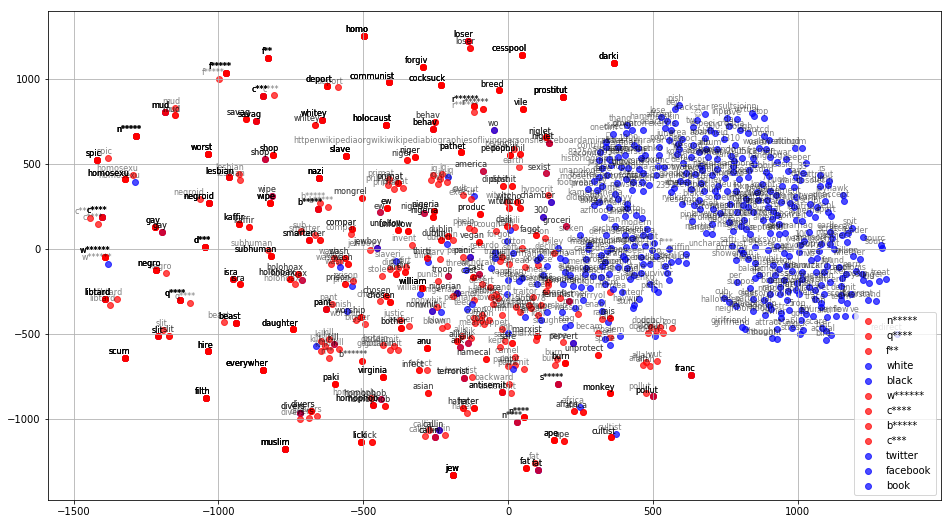

In [267]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters, 0.7)

In [217]:
import bokeh.io
from bokeh import palettes

colors = palettes.plasma(len(keys))

p = figure(plot_width = 1000, plot_height = 500)
for label, embeddings, words in zip(keys, embeddings_2d, word_clusters):
    if label in hate_words:
        color = 'red'
    else:
        color = 'blue'
    x_ = embeddings[:,0]
    y_ = embeddings[:,1]
    p.scatter(x_,y_, color = color, legend = label)
    
    p.legend.location = 'bottom_left'
    for i, word in enumerate(words):
        
        ann = Label(x = x_[i], y = y_[i], text = word, text_font_size = '7pt')
        p.add_layout(ann)
#p.scatter()
show(p)

In [134]:
test_pred = model.predict(X_test)
val_pred = model.predict(X_val)

In [135]:
test_pred_cat = [1 if val > 0.5 else 0 for val in test_pred]
val_pred_cat = [1 if val > 0.5 else 0 for val in val_pred]

In [125]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate

In [143]:
val_prec = precision_score(val_pred_cat, y_val)
val_acc = recall_score(val_pred_cat, y_val)
val_f1 = f1_score(val_pred_cat, y_val)
val_scores = [val_prec, val_acc, val_f1]

In [144]:
test_prec = precision_score(test_pred_cat, y_test)
test_acc = recall_score(test_pred_cat, y_test)
test_f1 = f1_score(test_pred_cat, y_test)
test_scores = [test_prec, test_acc, test_f1]

In [150]:
print(tabulate([['Precision', 'Accuracy', 'F1'],
                val_scores, test_scores], headers = 'firstrow'))

  Precision    Accuracy        F1
-----------  ----------  --------
   0.817708    0.788945  0.803069
   0.808354    0.810345  0.809348
